# Récupération des données

In [1]:
import pandas
import matplotlib
import matplotlib.pyplot as plt
import numpy
from sklearn.model_selection import train_test_split
from sklearn import metrics

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adamax
import tensorflow

from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.applications.mobilenet import MobileNet

%matplotlib inline
pandas.set_option('display.width', 100)
pandas.set_option('precision', 3)

tensorflow.random.set_seed(15)
numpy.random.seed(15)

Using TensorFlow backend.


In [2]:
Y_train = numpy.load('Y_train.npy')

In [3]:
X_train = numpy.load('X_train.npy')

## Train / Val Split

In [4]:
X_train, x_val, Y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=15)

In [5]:
print(X_train.shape)
print(Y_train.shape)
print(x_val.shape)
print(y_val.shape)

(1649, 64, 64)
(1649, 10)
(413, 64, 64)
(413, 10)


## Remise en forme des données

In [6]:
print(X_train.shape)
print(Y_train.shape)

(1649, 64, 64)
(1649, 10)


In [7]:
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
x_val_flat = x_val.reshape(x_val.shape[0], x_val.shape[1]*x_val.shape[2])
X_train_flat.shape

(1649, 4096)

In [8]:
Y_train[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [9]:
input_number = X_train_flat.shape[1]
output_number = 10
print('input nmuber = ', input_number)
print('output_number = ', output_number)

input nmuber =  4096
output_number =  10


In [10]:
X_train = numpy.expand_dims(X_train, axis=X_train.ndim)
x_val = numpy.expand_dims(x_val, axis=x_val.ndim)
X_train.shape

(1649, 64, 64, 1)

In [11]:
X_train_vide = numpy.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2], 3])
X_train_vide[..., :] = X_train[..., :]
X_train = X_train_vide

x_val_vide = numpy.empty([x_val.shape[0], x_val.shape[1], x_val.shape[2], 3])
x_val_vide[..., :] = x_val[..., :]
x_val = x_val_vide

X_train.shape

(1649, 64, 64, 3)

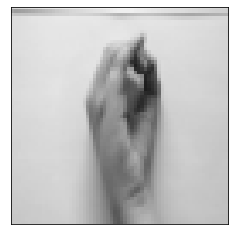

In [12]:
plt.imshow(X_train[10]);
plt.xticks([]), plt.yticks([]);

# Modèle nasnet (modèle pré-entraîné)

In [ ]:
pretrained_model = MobileNet(include_top=False, input_shape=(64, 64, 3), weights='imagenet')
for layer in pretrained_model.layers:
    layer.trainable = False  

model = Sequential()

for i in range(41):
    model.add(pretrained_model.layers[i])

# model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

callbacks = [EarlyStopping(monitor='val_accuracy', patience=10)]

loss = 'categorical_crossentropy'
LEARNING_RATE = 0.07
EPOCHS = 1000

model.compile(loss=loss,
               optimizer=Adamax(lr=LEARNING_RATE), # SGD(lr=LEARNING_RATE)
               metrics=['accuracy'])

history = model.fit(X_train[:1000],
                     Y_train[:1000],
                     epochs=EPOCHS,
                     validation_data=(x_val[:100], y_val[:100]),
                     batch_size=X_train.shape[0],
                     callbacks=callbacks)

/opt/conda/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Train on 1000 samples, validate on 100 samples
Epoch 1/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 5.1696 - accuracy: 0.1000 - val_loss: 156.8092 - val_accuracy: 0.1600
Epoch 2/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 133.4541 - accuracy: 0.2540 - val_loss: 353.8575 - val_accuracy: 0.1000
Epoch 3/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 300.3527 - accuracy: 0.1000 - val_loss: 524.3618 - val_accuracy: 0.0500
Epoch 4/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 445.6863 - accuracy: 0.1140 - val_loss: 616.0525 - val_accuracy: 0.1000
Epoch 5/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 548.2649 - accuracy: 0.0960 - val_loss: 702.8025 - val_accuracy: 0.0800


In [ ]:
model.summary()

In [ ]:
import pandas as pd
%matplotlib inline
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance throughout training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.ylim(bottom = 0, top = 1);
#plt.ylim(bottom = history.history['loss'][-1], top = history.history['loss'][5]);

In [ ]:
score = model.evaluate(x_val, y_val, verbose=0)
score

In [ ]:
y_predict = model.predict(x_val)

In [ ]:
y_predict[0]

In [ ]:
y_predict = pandas.DataFrame(y_predict)
y_predict.columns = ['0','1','2','3','4','5','6','7','8','9']
y_predict.head()

In [ ]:
for i in range(0, 10):
    y_predict.loc[y_predict[str(i)] == y_predict.agg(func=max, axis=1), str(i)] = 1
    y_predict.loc[y_predict[str(i)] < 1, str(i)] = 0

y_predict.head()

In [ ]:
y_val_mod = pandas.DataFrame(y_val)
y_val_mod.columns = ['0','1','2','3','4','5','6','7','8','9']
y_val_mod.head()

In [ ]:
y_val_mod = numpy.array(y_val)
y_predict = numpy.array(y_predict)

In [ ]:
def Y_transform(Y_train):
    Y_output = []
    for line in range(len(Y_train)):
        for col in range(10):
            value = str(int(Y_train[line][col]))
            if value == '1':
                Y_output += [str(col)]

    return Y_output

In [ ]:
y_val_flat = Y_transform(y_val_mod)
y_predict_flat = Y_transform(y_predict)

In [ ]:
conf_matrix = metrics.confusion_matrix(y_predict_flat, y_val_flat)
print(conf_matrix)
plt.imshow(conf_matrix, cmap='binary');